In [2]:

import json

with open("data/all_formatted_pre_data.json") as f:
    coin_data = json.load(f)


In [69]:
##ここで銘柄の選択を行う
data = big_coin_data["ADABTC"]

volume = data["volume"]
price = data["price"]

## 対数階差をとる

In [3]:
import numpy as np

def get_log_diff(data):
    # 対数を取り、差分を計算
    price_log = list(np.log(data))

    price_log_diff = []

    for i in range(len(price_log)-1):
        price_log_diff.append((price_log[i+1] - price_log[i])*10)

    return price_log_diff



### 定常性の検定

In [71]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(price_log_diff)

print("ADF Statistic:", end=" ")
print(result[0])

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print("p-value:", end=" ")
print(result[1])

ADF Statistic: -17.51943657969174
	1%: -3.448
	5%: -2.870
	10%: -2.571
p-value: 4.293219470692449e-30


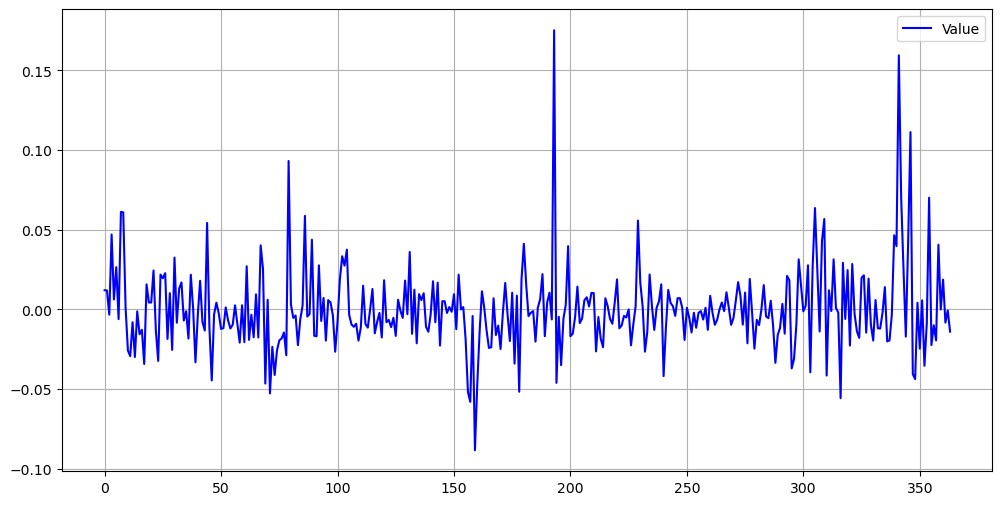

-0.00011322698984468165


In [72]:

import matplotlib.pyplot as plt

# 時系列データのプロット
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(len(price_log_diff))], price_log_diff, label='Value', color='b')  # 'Value'はプロットしたいカラム名
plt.legend()
plt.grid(True)
plt.show()

print(sum(price_log_diff)/len(price_log_diff))

In [73]:
from collections import defaultdict
model_param = defaultdict(list)

## ARモデルのパラメータ決定

In [4]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

def AR_param(data):
    model = AutoReg(data, lags=1)
    model_fit = model.fit()

    return model_fit.params[0], model_fit.params[1:]



## GARCHモデルのパラメータ決定

In [5]:
from arch import arch_model
import statistics
import copy

def GARCH_param(data):
    mean = statistics.pstdev(data)
    rescale = 10 ** (len(str(int(10/mean)))-1)
    train_data = copy.deepcopy(data)
    for i in range(len(train_data)):
        train_data[i] *= rescale
    model = arch_model(train_data, vol="GARCH", p=1, q=1)
    model_fit = model.fit()

    return model_fit.params["omega"], model_fit.params["alpha[1]"], model_fit.params["beta[1]"], rescale

In [83]:
x = coin_data["alpaca-finance"]["price"]

y = GARCH_param(x)

y

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4222572600.0499554
Iteration:      2,   Func. Count:     12,   Neg. LLF: 12199.91683521648
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1148.5653510198244
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3951.3437645593995
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1301.4578259390896
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1099.1265280574503
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1037.533459051308
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1133.1311688890426
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1094.2420155395807
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1084.5052647651437
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1092.3169358153061
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1084.8133895392084
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1080.3557480217405
Iteration:     14,   Func. Count:     88,   Neg. LLF:

(0.12230075445745463, 0.8369067928181847, 0.16309320718181536, 100)

## 取引量の変動についてのパラメータ決定

### AIC計算関数

In [6]:
import math

## model_data→生成されたデータリスト
## data→元のデータリスト
## t→生成されたデータの長さ
## p→ARモデルの次元数
def aic(model_data, data, t, p):
    sum_value = 0
    for i in range(len(model_data)):
        sum_value += (model_data[i] - data[i+p]) ** 2
    return math.log(sum_value/t) + 2*(p+1)/t

### モデルを使ってデータを生成するための関数

In [16]:
import numpy as np

## test_param→値を得たいパラメータ
def model_check(const, a, omega, alpha, beta, p, test_param, price_data, value_data):
    volatility = [np.random.normal(loc=0, scale=1)]
    list_h = [0]
    generated_data_value = []
    for i in range(len(price_data)-p):
        x = 0
        for j in range(p):
            x += price_data[i+j] * a + const
            if j == p-1:
                x += value_data[i+j] * test_param
        h = omega + alpha * volatility[-1] + beta * list_h[-1]
        vol = h * np.random.normal(loc=0, scale=1)
        x += vol
        volatility.append(vol)
        list_h.append(h)
        generated_data_value.append(x)
    return generated_data_value


### パラメータ推定

In [17]:
## 対数階差をとる

import numpy as np

def get_volume_param(main_data, sub_data, const, a, omega, alpha, beta, p):
    # 対数を取り、差分を計算
    volume_log = list(np.log(sub_data))

    volume_log_diff = []

    for i in range(len(volume_log)-1):
        volume_log_diff.append((volume_log[i+1] - volume_log[i]) * 100)


    check_data = []

    for i in range(1, 2001):
        test_param = (i-1000)/1000
        param_return = model_check(const=const, a=a, omega=omega, alpha=alpha, beta=beta, p=p, test_param=test_param, price_data=main_data, value_data=volume_log_diff)
        target_value = aic(model_data=param_return, data=main_data, t=len(main_data), p=p)
        check_data.append(target_value)
    

    volume_param = (check_data.index(min(check_data))-1000)/1000
    return volume_param

In [93]:
volume_param = get_volume_param(volume)


NameError: name 'volume' is not defined

## 生成されたパラメータの保存

In [80]:
save_data = [const, a, omega, b, volume_param]

model_param["ADABTC"] = save_data

In [18]:
from collections import defaultdict

save_values = {}
error_key = []
for key, value in coin_data.items():
        model_param = defaultdict(list)
        save_data = defaultdict(list)
        price_value = value["price"]
        volume_value = value["volume"]
        price_formatted_value = get_log_diff(price_value)
        a, const = AR_param(price_formatted_value)
        save_data["a"] = a
        save_data["const"] = const
        omega, alpha, beta, rescale = GARCH_param(price_formatted_value)
        save_data["omega"] = omega
        save_data["alpha"] = alpha
        save_data["beta"] = beta
        save_data["rescale"] = rescale
        param_estimate_value = get_volume_param(main_data=price_formatted_value, sub_data=volume_value, const=const, a=a, omega=omega, alpha=alpha, beta=beta, p=1)
        save_data["param_estimate_value"] = param_estimate_value
        save_values[key] = save_data


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1340.0818129466443
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1381.687762274425
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1114.224280392054
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1115.9283854495393
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1126.2554592132187
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1140.9291817639448
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1113.1968505177588
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1416.7083008476454
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1103.7055011377959
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1103.7051604004628
Iteration:     11,   Func. Count:     67,   Neg. LLF: 1103.7051273410634
Iteration:     12,   Func. Count:     72,   Neg. LLF: 1103.7051231300911
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1103.705123129249
Optimization terminated successfully    (Exit mode 0)


/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_8047/2113743210.py:7: RuntimeWarning: divide by zero encountered in log
  volume_log = list(np.log(sub_data))
/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_8047/2113743210.py:12: RuntimeWarning: invalid value encountered in double_scalars
  volume_log_diff.append((volume_log[i+1] - volume_log[i]) * 100)
/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_8047/213262607.py:13: RuntimeWarning: invalid value encountered in double_scalars
  x += value_data[i+j] * test_param


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1580.022905703091
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1391.3039360857474
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1086.0705034575722
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1219.2599351771025
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1048.1895065181438
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1048.1876553558577
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1048.187603593371
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1048.1876026074972
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1048.1876026074972
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1577.9940625896138
Iteration:      2,   Func. Count:     13,   Neg. LLF: 976.9749523794239
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1037.794570

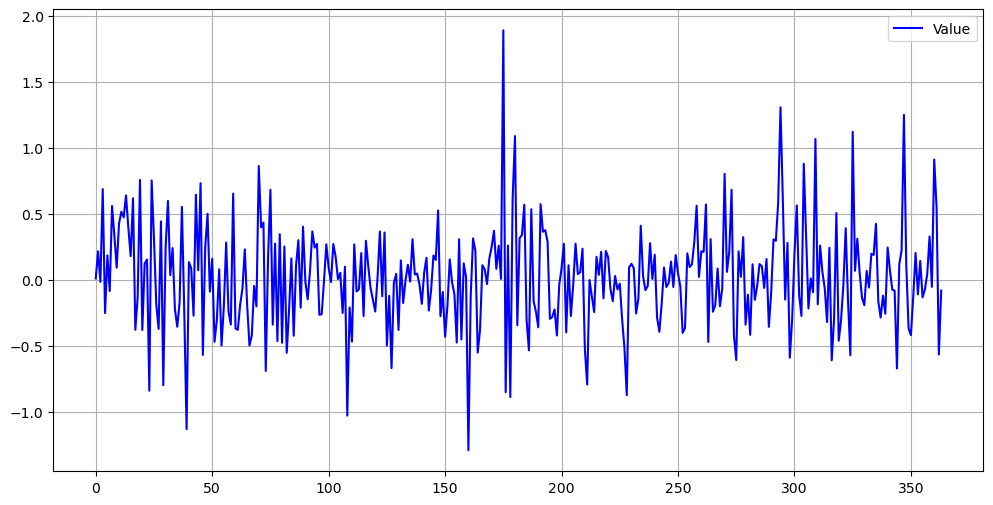

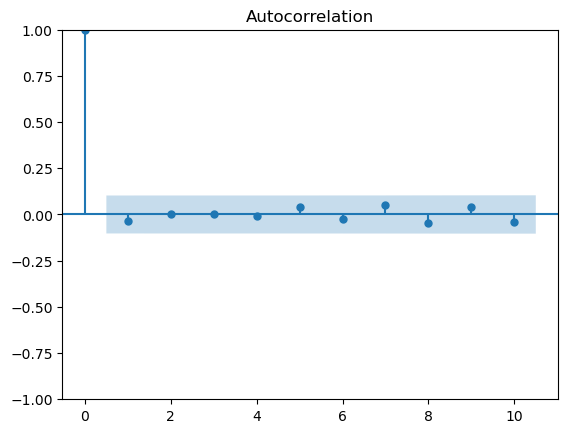

In [40]:
test = coin_data["aave"]["price"]
price_log_diff = get_log_diff(test)

plt.figure(figsize=(12, 6))
plt.plot([i for i in range(len(price_log_diff))], price_log_diff, label='Value', color='b')  # 'Value'はプロットしたいカラム名
plt.legend()
plt.grid(True)
plt.show()


from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# 自己相関のプロット
plot_acf(price_log_diff, lags=10)  # ラグ10まで計算
plt.show()

In [20]:
save_values

{'0x': defaultdict(list,
             {'a': 0.023539428865052992,
              'const': array([0.03457681]),
              'omega': 1.358181807318826,
              'alpha': 0.012799652893279391,
              'beta': 0.9361183727976171,
              'rescale': 10,
              'param_estimate_value': -0.127}),
 '1inch': defaultdict(list,
             {'a': 0.002155252777483798,
              'const': array([0.05306894]),
              'omega': 3.5354691816206527,
              'alpha': 0.19340821469905364,
              'beta': 0.5679857453280573,
              'rescale': 10,
              'param_estimate_value': -0.015}),
 'bakerytoken': defaultdict(list,
             {'a': 0.03872822626988396,
              'const': array([-0.00730675]),
              'omega': 1.5354972288190145,
              'alpha': 0.07640165670513183,
              'beta': 0.909489232627773,
              'rescale': 10,
              'param_estimate_value': -0.018}),
 'aave': defaultdict(list,
             {

In [11]:
for key, value in save_values.items():
    value["a"] = list(value["a"])



TypeError: 'numpy.float64' object is not iterable

In [21]:
import numpy as np
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

with open("data/all_prices_param_data.json", "w") as file:
    json.dump(save_values, file, cls=NumpyEncoder, indent=4)

In [83]:
ave = sum(ans[365:])/300
ave

0.0028902730089806635

/Users/hiroki/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hiroki/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hiroki/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hiroki/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25955 (\N{CJK UNIFIED IDEOGRAPH-6563}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


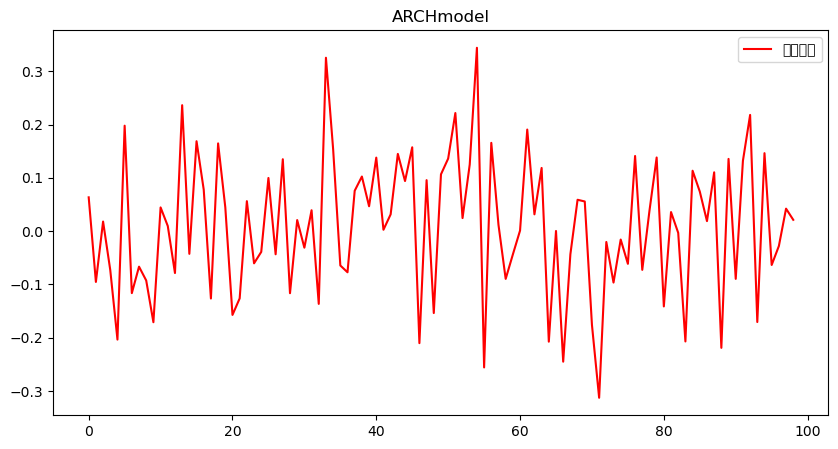

In [86]:
# 予測結果のプロット
plt.figure(figsize=(10, 5))
plt.plot([i for i in range(100-1)], ans[365:], label='予測分散', color='red')
plt.title('ARCHmodel')
plt.legend()
plt.show()